## Práctica de pre-procesamiento y del algoritmo KNN

- [Análisis Exploratorio de Datos](#Análisis-Exploratorio-de-Datos)
- [Transformación](#Transformación)
- [Detección de outliers](#Detección-de-outliers)
- [Estandarización](#Estandarización)
- [Problemas de regresión con el algoritmo KNN](#Problemas-de-regresión-con-el-algoritmo-KNN)
- [Data leakage](#Data-leakage)
- [Pipelines](#Pipelines)
- [Problemas de clasificación con el algoritmo KNN](#Problemas-de-clasificación-con-el-algoritmo-KNN)

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from test_helper import Test

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline  

### Lectura de Datos

En esta práctica vamos a trabajar con un problema de regresión. En concreto vamos a trabajar con el problema de la predicción del valor de una casa en base a su superficie y a su número de habitaciones. 

Para ello tenemos un fichero con el histórico de casas de  una empresa que tiene sede en Estados Unidos y en España: 
* El fichero es datosRegresion.txt y contiene casas caracterizadas por su superficie y su número de habitaciones de las que se dispone de su valoración.

Leer los datos almacenados en dicho fichero mediante la función *read_csv* de Pandas (asignad el tipo de datos a *float32*, *dtype='float32'*) y genera dos DataFrames para almacenar los datos de entrada (X) y de salida (y).

In [3]:
# Creamos una lista con los nombres de las variables de entrada y el string con el nombre de la variable de salida respectivamente
# variablesEntrada =  <RELLENAR>
# variableSalida =  <RELLENAR>
variablesEntrada = ['Superficie','NumHabitaciones']
variablesSalida = ['Valoracion']
# Lectura de datos, el delimitador de atributos es la coma ',' y se deben leer con formato float32
# datos = <RELLENAR>
datos = pd.read_csv('datosRegresion.txt',delimiter=',',dtype='float32')
# Generamos dos DataFrames: uno para la información de entrada (X) y otro para la de salida (y)
    # para acceder a los datos se debe usar el método loc 
    # para realizar una copia rompiendo la referencia a la variable original se debe usar el método copy
# X = <RELLENAR>
X = datos.loc[:, variablesEntrada].copy()
# y = <RELLENAR>
y = datos.loc[:, variablesSalida].copy()

### Análisis exploratorio de datos

En primer lugar vamos a mostrar el resumen estadístico de la información de las variables de entrada y de salida. Para ello se puede utilizar el método [*describe*](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html).

In [11]:
resumenEntrada = X.describe()
resumenSalida = y.describe()

print(resumenEntrada)

        Superficie  NumHabitaciones
count    57.000000        57.000000
mean   1685.280762         3.649123
std     999.112244         3.632646
min      98.000000         1.000000
25%    1203.000000         3.000000
50%    1664.000000         3.000000
75%    2162.000000         4.000000
max    4478.000000        30.000000


Como las variables en las que recogemos los datos también son DataFrames podemos acceder fácilmente al contenido de cualquier valor estadístico. Se muestran varios ejemplos en la celda posterior.

In [10]:
# Acceso a las medias de todos los atributos de entrada
print(resumenEntrada.loc['mean', :],flush=True)
# Acceso al mínimo de la superficie
print(resumenEntrada.loc['min', 'Superficie'],flush=True)
# Acceso al mínimo y al máximo del número de habitaciones
print(resumenEntrada.loc[['min', 'max'], 'NumHabitaciones'],flush=True)
# Acceso al conteo del número de valores de la valoración
print(("El número de ejemplos de la variable de salida es {}").format(resumenSalida.loc['count']),flush=True)

Superficie         1685.280762
NumHabitaciones       3.649123
Name: mean, dtype: float64
98.0
min     1.0
max    30.0
Name: NumHabitaciones, dtype: float64
El número de ejemplos de la variable de salida es Valoracion    57.0
Name: count, dtype: float64


Para ver la complejidad del problema podemos inspeccionar visualmente la relación entre cada variable de entrada y la variable a predecir. Para mejorar dicha visualización, en el caso de problemas de regresión, es interesante mostrar los valores de la variable de entrada ordenados (evidentemente la variable de salida deberá estar ordenada de acuerdo a dicha ordenación).

Para ello, mostrad dos gráficas en la que en cada una se muestre en el eje X la variable de entrada correspondiente (ordenada de enor a mayor) y en el eje y la valoración para cada valor. Para ello podéis utilizar la función [*relplot*](https://seaborn.pydata.org/generated/seaborn.relplot.html) de la librería *seaborn* (importada como sns). A dicha función se le debe pasa como valor *x* la variable de entrada, como valor *y* la variable de salida y podéis cambiar su tamaño cambiando el valor de *height*. Además, podéis poner títulos a los ejes y a la figura si almacenáis en una variable el objeto que devuelve *relplot* y luego utilizáis el método *set* (eje x: *xlabel*, eje y: *ylabel*, título general: *title*).

NOTAS: 
* Para acceder al contenido de los DataFrames/Series se usa el método *loc*
* Para obtener a los índices de un DataFrame/Series se usa la propiedad *index* y se puede crear una lista haciendo *cast* a *list*

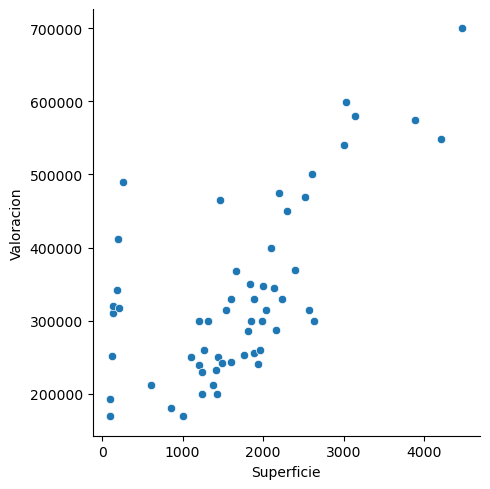

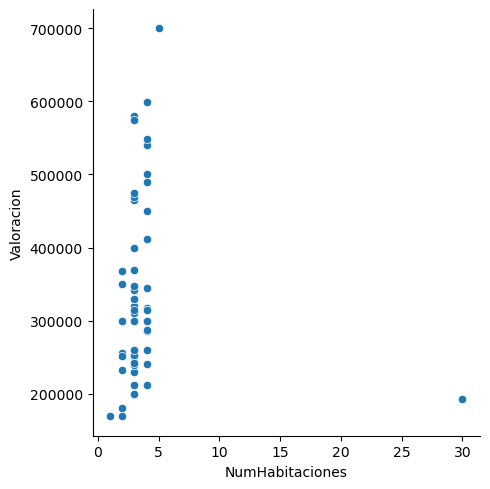

In [24]:
# Variables para obtener los índices de los ejemplos tras ordenarlos de menor a mayor en cada variable de entrada
ind_superficie = X['Superficie'].sort_values().index
ind_numHabitaciones = X['NumHabitaciones'].sort_values().index
# Creamos el gráfico 
sns.relplot(x=X.loc[ind_superficie,'Superficie'],y = y.loc[ind_superficie,'Valoracion'])
sns.relplot(x=X.loc[ind_numHabitaciones,'NumHabitaciones'],y=y.loc[ind_numHabitaciones,'Valoracion'])

Otra cosa útil es analizar el contenido de las variables de entrada para poder detectar su comportamientos (y posibles problemas). Por ello, vamos a mostrar gráficamente el contenido de las variables de entrada. 

Para ello, debéis crear una gráfica compuesta por dos subgráficas (1 fila y 2 columnas) de tamaño (14,7) utilizando el método [*subplots*](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) de la librería *matplotlib*. A este método se le pasa el número de filas, el número de columnas y el tamaño (*figsize*). Este método devuleve el manejador de la figura y el de los ejes (es un vector/matriz con tantos elementos como subgráficas se hayan determinado: filas x columnas). 

En cada subgráfica se debe mostrar el contenido de una de las variables de entrada y para ello se puede utilizar el método [*lineplot*](https://seaborn.pydata.org/generated/seaborn.lineplot.html) de la librería *seaborn*. A dicha función se le pasa como *data* el contenido de la variable y para determinar en qué subfigura se muestra se debe utilizar el parámetro *ax* al que se pasa un elemento del manejador de ejes devuelto por *subplots*. 

Además, para facilitar la interpretación de los resultados se suele utilizar el *grid* (sns.set_style("ticks",{'axes.grid' : True})).

Text(0.5, 1.0, 'NumHabitaciones')

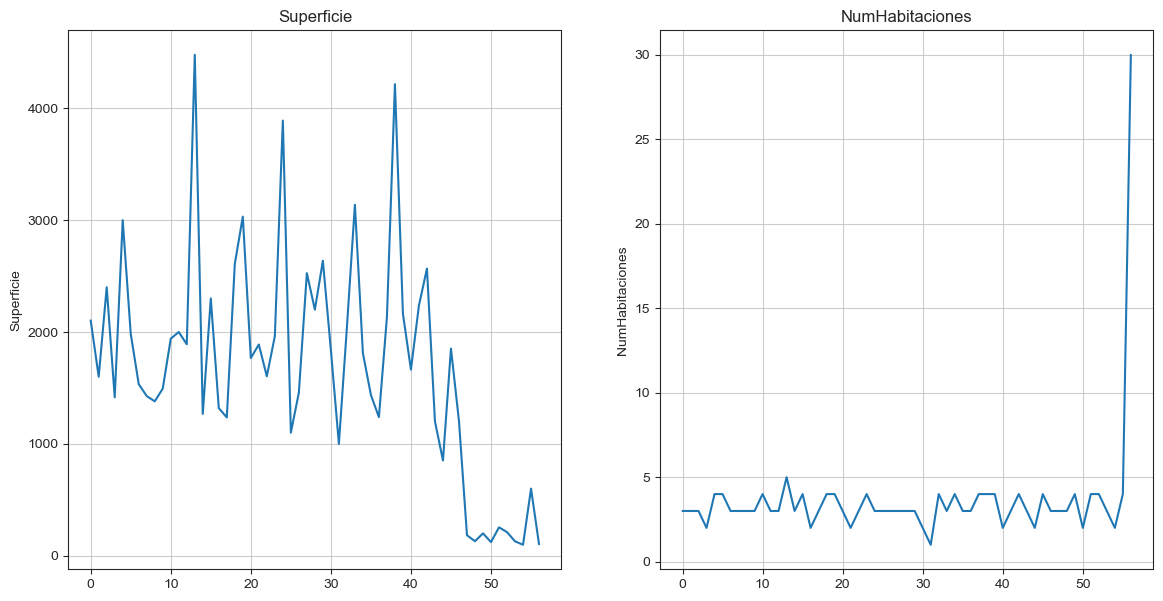

In [25]:
sns.set_style("ticks", {'axes.grid': True})

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.lineplot(data=X['Superficie'], ax=axes[0])
axes[0].set_title('Superficie')

sns.lineplot(data=X['NumHabitaciones'], ax=axes[1])
axes[1].set_title('NumHabitaciones')

A continuación vamos a mostrar gráficamente la distribución de los datos de las variables de entrada junto con los diagramas de cajas y bigotes (boxplot). Para ello, cread una gráfica compuesta por 4 subgráficas (2 filas y 2 columnas).

En cada fila, en la columna izquierda mostrad la distribución de los datos de una variable usando [*histplot*](https://seaborn.pydata.org/generated/seaborn.histplot.html) y en la columna de la derecha mostrad el [*boxplot*](https://seaborn.pydata.org/generated/seaborn.boxplot.html) de la misma variable. Ambas funciones reciben el DataFrame a mostrar en el parámetro *data* y en los parámetros *x* o *y* simplemente se debe especificar el nombre de la variable que se desea mostrar (de las del DataFrame evidentemente). Además, se puede modificar el color (*color*) y elegir la subgráfica (*ax*) para mostrar el contenido.

NOTA: cread el histograma utilizando 20 contenedores (bins). Podéis especificar *kde* a *True* para visualizar mejor la distribución de los datos.

In [ ]:
# <RELLENAR>

Podemos observar que en la superficie existe un problema de escala (recordad que la empresa tiene sedes en EEUU y en España) ya que en el plot se observa que los últimos valores son mucho más pequeños que los primeros y esto se confirma en el histograma con la presencia de muchos datos cercanos a 0 y luego una distribución normal. Además, podemos ver que existen varios outliers. Con respecto al número de habitaciones, podemos observar que no existen problemas de escala pero que si que tenemos algún outlier en los datos.

### Transformación

En primer lugar vamos a tratar de solucionar el problema de escala. El hecho de que la empresa tenga sedes en EEUU y en España nos hace pensar que unas casas estarán medidas en pies cuadrados y otras en metros cuadrados (1 $m^2$ = 10,7639 $pies^2$). Por ello, debemos transformar todas las superficies medidas en pies cuadrados a metros cuadrados. **Esta transformación se puede hacer a todos los datos puesto que no requiere de un proceso de aprendizaje** (en ese caso habría que aprender con los datos de train y con el objeto aprendido habría que realizar la trasnformación de los datos que fueran).

Vamos a utilizar el valor 750 como umbral para decidir las casas medidas en una unidad métrica u otra (las mayores de 750 las consideraremos medidas en pies cuadrados).

In [ ]:
# <RELLENAR>

In [ ]:
Test.assertEquals(list(map(lambda x: round(x, 2), X['Superficie'].head())), [195.47, 148.65, 222.97, 131.55, 278.71], 'Superficies transformadas incorrectamente')

### División de datos en conjuntos de entrenamiento, validación y test

Antes de comenzar a aplicar diferentes técnicas de prepración de datos y/o aprendizaje automático es importante dividir los datos disponibles en, como mínimo, los conjunto de entrenamiento y de test. Habitualmente utilizaremos 3 conjuntos de datos para realizar el proceso de validación de modelos:
* Conjunto de entrenamiento: utilizado para aprender los parámetros de los modelos para una determinada configuración de los valores de los híper-parámetros del mismo.
* Conjunto de validación: utilizado para determinar los mejores valores de los híper-parámetros de los modelos (en el caso de problemas de clasificación también puede ser utilizado para determinar el mejor umbral de clasificación).
* Conjunto de test: utilizado para ver la calidad del mejor modelo obtenido en los pasos anteriores. Solo se utiliza una vez.

Existen diferentes metodologías para obtener dichos conjuntos (las veremos en teoría). La librería Scikit-learn tiene implementaciones de varias de estas metodologías y todas ellas se encuentran en la librería [*model_selection*](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection).

Para esta práctica vamos a utilizar la metodología más simple que consiste en elegir aleatoriamente (sin reemplazamiento) un porcentaje de ejemplos para generar cada conjunto. A esta metodología se le conoce como **Hold-out**.

Dentro de la librería *model_selection* se encuentra la función llamada [*train_test_split*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) que nos realiza el proceso de división de los datos aplicando la técnica Hold-out. La función recibe varias variables de entrada y devuelve varias de salida, la llamada a dicha función es la siguiente:

    X_train, X_test, y_train, y_test = model_selection.train_test_split(inputData, outputData, train_size=porcentajeTrain, test_size=porcentajeTest, stratify=variableEstratificacion, random_state=semilla)

* Los parámetros de entrada son:
    * inputData: los datos de entrada
    * outputData: los datos de salida
    * porcentajeTrain/porcentajeTest: la proporción de ejemplos de entrenamiento/test (si se especifica uno el resto de ejemplos son asignados al otro conjunto)
        * Un valor entero representa el número de ejemplos a utilizar
        * Un valor real representa la proporción de ejemplos a utilizar
    * semilla: valor de la semilla para poder generar los mismos números aleatorios y poder reproducir los resultados.
    * variableEstratificacion: variable a utilizar para realizar el proceso de estatificación en caso de problemas de clasificación (para los de regresión no se aplica)
* Los parámetros de salida son:
    * X_train: los datos de entrada del conjunto de entrenamiento
    * X_test: los datos de entrada del conjunto de test
    * y_train: los datos de salida del conjunto de entrenamiento
    * y_test: los datos de salida del conjunto de test

Vamos a generar 3 conjuntos de datos: entrenamiento, validación y test. Para ello, en primer lugar vamos a generar el conjunto de test al que asignaremos el 10% de los ejemplos). El resto de ejemplos lo volveremos a dividir para generar el conjunto de entrenamiento (80%) y el conjunto de validación (resto de ejemplos). En todos los casos utilizaremos el valor 123 como semilla.

In [ ]:
from sklearn.model_selection import train_test_split

# Creación de los conjuntos de test (10% de los ejemplos) y el resto de ejemplos
# aux_X, X_test, aux_y, y_test = <RELLENAR>
# Creación de los conjuntos de train (80% de los ejemplos) y de validación (resto de los ejemplos)
# X_train, X_val, y_train, y_val =  <RELLENAR>

### Detección de outliers

La primera técnica de preparación de datos que vamos a implementar es el método de detección de outliers basado en el rango intercuartil. Además, en caso de que se detecten outliers se deben sustituir por la mediana de los valores de la variable en la que se han encontrado.

Para ellop, vamos a implementar nuestro propio método de detección y tratamiento de outliers pero de forma que sea compatible con Scikit-learn (para poder utilizar las *Pipelines*, *GridSerachCV*, etc...). Para ello, Scikit-learn nos ofrece la clase llamada [*TransformerMixin*](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) que permite implementar una nueva clase para realizar procesos de pre-procesamento con sus respectivos constructores y los métodos *fit* y *transform* para imitar el funcionamiento de todo el resto de clases de Scikit-learn.

En concreto, se debe definir una clase, llamada *OutlierDetecion_treatment_IQR*, que:
* Su constructor reciba el valor del híper-parámetro k, encargado de determinar si son outliers extremos o no. Por defecto debe tomar el valor 1.5.
* El método *fit* debe recibir como parámetros de entrada el conjunto de ejemplos con el que aprender (X) y, para que sea compatible con Scikit-learn, tambiéb debe recibir las salidas de dichos datos (y). En nuestro caso el valor por defecto de y deberá ser *None* ya que no es necesario para el aprendizaje. El método debe realizar las operaciones necesarias para obtener los valores necesarios para aplicar el método del rango IQR. Es decir, debe almacenar el resultado del método *describe* de *Pandas*. Almacenará el resultado en un propiedad (self.) llamada *stats*. 
    * Para acceder posteriormente a esta variable se debe utilizar *self.stats*. 
* El método *transform* debe realizar la detección de outliers mediante el método del rango IQR y en caso de detectar algún outlier, se debe sustituir por la mediana de los valores de la variable en la que haya sido detectado. Este método devolverá el DataFrame modificado.

NOTA: el método *logical_or* de Numpy realica la unión lógica de dos listas de booleanos.

In [ ]:
# Importamos la clase TransformerMixin
from sklearn.base import TransformerMixin

# Creamos la clase de detección y tratamiento de Outliers
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
#         self.stats = <RELLENAR>
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
#         Xaux = <RELLENAR>
        # Se calcula el IQR de cada variable
#         IQRs = <RELLENAR>
        # Se calculan los límites inferiores y superiores   
#         limiteInf = <RELLENAR>
#         limiteSup = <RELLENAR>
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
#         menores = <RELLENAR>
#         mayores = <RELLENAR>

        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
#             indices = <RELLENAR>
            # Si hay outliers
            # <RELLENAR>
                # Los sustituimos por la mediana
                # <RELLENAR>
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

Para comprobar que el método funciona, vamos a probarlo utilizando los datos de entrenamiento. Debéis detectar y tratar los outliers extremos (k=3).

In [ ]:
# Instanciamos la clase anterior (llamamos out_IQR al objeto), la entrenamos con los datos de train y transformamos el conjunto de train
# out_IQR = <RELLENAR>
# X_train_IQR = <RELLENAR>

In [ ]:
Test.assertEquals(list(map(lambda x: round(x, 2), X_train_IQR.loc[[7,55,56]]['Superficie'].tolist())), [132.57, 177.82, 102.0], 'Superficie mal tratada')
Test.assertEquals(list(map(lambda x: round(x, 2), X_train_IQR.loc[[7,55,56]]['NumHabitaciones'].tolist())), [3, 4, 3], 'Numero de habitaciones mal tratado')

Ahora vamos a realizar el mismo proceso pero para el método de detección de outliers basado en la media y la desviación estándar explicado en clase de teoría. 

Definir una clase llamada *OutlierDetecion_treatment_MeanStd* con las siguientes características:
* El constructor debe recibir y almacenar el valor del híper-parámetro k (determina si es outlier extremo o no) cuyo valor por defecto debe ser 2.
* El método *fit* recibe como entradas los datos de entrada, X, y las salidas, y (debe ser *None*), y aprende y almacena la media, la desviación estándar y la mediana por cada variable de entrada.
* El método *transform* recibe el DataFrame a transformar. Para ello, detecta los outliers y en caso de que haya los sustituye por la mediana de los datos de la variable en la que se hayan detectado.
* El método *set_params* es el mismo que el presentado en el caso anterior.

In [ ]:
# Creamos la clase de detección y tratamiento de Outliers
# <RELLENAR>

Para comprobar que el método funciona, vamos a probarlo utilizando los datos de entrenamiento. Debéis detectar y tratar los outliers (k=2).

In [ ]:
# Instanciamos la clase anterior  (llamamos out_media_std al objeto), la entrenamos y transformamos del DataFrame
# out_media_std = <RELLENAR>
# X_train_meanStd = <RELLENAR>

In [ ]:
Test.assertEquals(list(map(lambda x: round(x, 2), X_train_meanStd.loc[[7,55,56]]['Superficie'].tolist())), [132.57, 177.82, 102.0], 'Superficie mal tratada')
Test.assertEquals(list(map(lambda x: round(x, 2), X_train_meanStd.loc[[7,55,56]]['NumHabitaciones'].tolist())), [3, 4, 3], 'Numero de habitaciones mal tratado')

### Estandarización

En los datos iniciales se puede observar que el rango de las dos variables de entrada es muy diferente. Por este motivo se debe realizar un proceso de estandarización de los datos para que todas las variables de entrada tengan el mismo rango y, por tanto, la misma importancia.

Vamos a ver dos formas de realizar la estandarización. La primera de ellas es el método basado en la media y la desviación estándar. La librería Scikit-Learn de Python nos provee una clase que realiza este proceso de estandarición (usa la varianza en lugar de la desviación estándar). Dicha clase está dentro de la librería *Preprocessing*. La clase en concreto que realiza este proceso es la llamada [*StandardScaler*](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler). 

Para crear un objeto de esta clase es suficiente con llamar al constructor: *preprocessing.StandardScaler()*. Esta llamada devuelve un objeto con el que podemos llamar a varios métodos, los que vamos a utilizar son:
* fit: recibe como parámetro de entrada los datos de entrenamiento y calcula la media y la desviación estándar para cada variable. La media queda almacenada en el campo mean_ y la varianza en el campo var_.
* transform: recibe como parámetro de entrada los datos a estandarizar y devuelve los datos estandarizados utilizando los valores aprendidos previamente y almacenados en mean_ y var_.
* fit_transform: realiza el proceso de ambas funciones previamente descritas en una sola función.


In [ ]:
from sklearn import preprocessing

normalizarScikitPorMedia = preprocessing.StandardScaler()

El segundo método de estandarización es el basado en el mínimo y el máximo de los datos de entrenamiento. La librería Scikit-Learn de Python también nos provee una clase que realiza este proceso de estandarización. La clase en concreto que realiza este proceso es la llamada [*MinMaxScaler*](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler). 

Para crear un objeto de esta clase es suficiente con llamar al constructor: *preprocessing.MinMaxScaler()*. Esta llamada devuelve un objeto con el que podemos llamar a los mismos métodos explicados para la clase *StandardScaler*. En este caso el valor mínimo para cada variable (calculado con el método *fit*) queda almacenado en el campo `data_min_` y el máximo en el campo `data_max_`. 

In [ ]:
normalizarScikitPorMinMax = preprocessing.MinMaxScaler()

### Problemas de regresión con el algoritmo KNN

A continuación vamos a aplicar todas las funciones definidas anteriormente para realizar la fase de solucionar el problema de la valoración de las casas. 

En este caso vamos a aplicar el algoritmo de los K vecinos más cercanos para problemas de regresión. La librería Scikit-Learn nos ofrece una implementación de dicho método que está dentro del paquete neighbors y cuya clase específica es [*KNeighborsRegressor*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor).

Lo primero que se debe realizar es llamar a la función que crea el modelo de regresión. Esta función tiene varios parámetros que determinan el comportamiento del algoritmo. La llamada al constructor y sus parámetros son los siguientes:

    modeloRegresion = neighbors.KNeighborsRegressor(n_neighbors  = K, weights = tipoVoto, metric = tipoDistancia, p = r)

Los diferentes parámetros de entrada son
* n_neighbors = K: número de vecinos a considerar (valor por defecto = 5)
* weights = tipoVoto: forma de votar (peso de cada ejemplo cercano). tipoVoto puede tomar los siguientes valores:
    * 'uniform': voto por mayoría  (valor por defecto)
    * 'distance': voto en función de la inversa de la distancia
* metric = tipoDistancia: forma de calcular la distancia entre los ejemplos.  tipoDistancia puede tomar los siguientes valores:
    * 'manhattan': distancia de manhattan
    * 'euclidean': distancia euclidea
    * 'minkowski': distancia de Minkowski (valor por defecto)
* r: en caso de utilizar la distancia de Minkowski hay que especificar el valor del parámetro p que se corresponde al exponente r visto en la clase de teoría. r puede cualquier valor, entre ellos:
    * r = 1: distancia de manhattan
    * r = 2: distancia euclidea (valor por defecto)
    
Crear el modelo inicial con todos los valores por defecto. Almacenar el modelo en una variable.

In [ ]:
from sklearn import neighbors
# modeloReg = <RELLENAR>

Una vez creado el modelo debemos entrenarlo. Para ello se debe llamar al método *fit* del objeto creado anteriormente. A dicho método se le deben pasar los datos de entrenamiento originales (con outliers) tanto de las variables de entrada como de la salida.

In [ ]:
# modeloReg = <RELLENAR>

Una vez que el modelo está entrenado lo podemos utilizar para realizar predicciones de nuevos datos. Para ello se debe llamar al método *predict* al que se pasa como parámetro de entrada los ejemplos a predecir (en este caso vamos a predecir el valor de los ejemplos originales de entrenamiento). Guardar el resultado de las predicciones en una variable.

In [ ]:
# predicciones = <RELLENAR>

En este punto ya tenemos las predicciones de todas las casas de entrenamiento con sus valores originales (con outliers) por lo que podemos calcular el rendimiento del modelo. La librería Scikit-Learn ofrece una función que calcula la raíz del error cuadrático medio de las predicciones. Este método está dentro del paquete *metrics* y se llama [*root_mean_squared_error*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html). A esta función se le pasa como argumentos de entrada los valores reales de los ejemplos y las predicciones realizadas por el modelo. Obviamente, devuelve la raíz del error cuadrático medio de las predicciones realizadas.

Utilizar dicha función para calcular la raíz del error cuadrático medio (RMSE) de las predicciones realizadas anteriormente.

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_squared_error

# errorTrain =  <RELLENAR>

In [ ]:
Test.assertEquals(errorTrain, np.float32(70874.41), 'Error incorrecto')

Una vez que tenemos el clasificador entrenado, lo podemos utilizar para predecir cualquier ejemplo. En este caso, vamos a predecir los valores de los ejemplos del conjunto de validación y vamos a obtener el RMSE.

In [ ]:
# errorVal =  <RELLENAR>
round(errorVal, 2)

In [ ]:
Test.assertEquals(round(errorVal, 2), np.float32(51370.6), 'Error incorrecto')

Una vez que sabemos utilizar la librería de Scikit-Learn para aplicar el algoritmo KNN de regresión, vamos a utilizarla para entrenar KNN pero con las casas en las que hemos tratado los outliers detectados por el método del rango intercuartil, predecir sus valores y obtener el error. Deberemos obtener el error para las casas de entrenamiento y las de validación. 
* Para obtener el error de entrenamiento debemos entrenar KNN con los datos de entrenamiento sin outliers, obtener sus predicciones y calcular el RMSE.
* Para obtener el error de validación debemos utilizar el objeto de la clase para detectar outliers entrenado previamente y aplicarlo a los datos de validación. Posteriormente, deberemos obtener las predicciones para esos datos y calcular el RMSE.

¿Es menor o mayor que el anterior? ¿Tiene sentido?

In [ ]:
# errorTrain_IQR =  <RELLENAR>
# Datos de validación sin outliers
# X_val_IQR = <RELLENAR>
# errorVal_IQR = <RELLENAR>

In [ ]:
Test.assertEquals(round(errorTrain_IQR, 2), np.float32(54546.10), 'Error en train incorrecto')
Test.assertEquals(round(errorVal_IQR, 2), np.float32(51275.26), 'Error en test incorrecto')

Finalmente, vamos a aplicar la estandarización de los datos a la hora de realizar las predicciones. Para ilustrar su efecto vamos a realizar la estandarización por el método de la media y la desviación estándar sobre los ejemplos preprocesados con el método de detección y tratamiento de outliers del rango intercuartil.

Debéis realizar lo siguiente:
* Entrenar el objeto de la clase StandardScaler con los ejemplos de entrenamiento apropiados
* Realizar el aprendizaje de KNN con los ejemplos de entrenamientoestandarizados
* Realizar la predicción de los ejemplos de entrenamiento estandarizados
* Calcular el RMSE

In [ ]:
# Llamada a la función de estandarización de datos (almacenar el objeto en la variable estandarizador) y aprendizaje del modelo
# estandarizador = <RELLENAR>
# error_X_IQR_estandarizadoStd = <RELLENAR>

In [ ]:
Test.assertEquals(round(error_X_train_IQR_estandarizadoStd, 2), np.float32(55292.50), 'Error incorrecto')

Obtener el RMSE de los ejemplos de validación (tratando los outliers y estandarizando).

In [ ]:
# error_X_val_IQR_estandarizado =   <RELLENAR>

In [ ]:
Test.assertEquals(round(error_X_val_IQR_estandarizado, 2), np.float32(58392.84), 'Error incorrecto')

### Data leakage 

Imaginar que el modelo anterior es lo mejor que hemos podido obtener. Ahora lo deberíamos probar con los datos de test para hacernos una idea de cómo va a funcionar el modelo con nuevos datos.

In [ ]:
# error_X_test_IQR_estandarizado = <RELLENAR>

In [ ]:
Test.assertEquals(round(error_X_test_IQR_estandarizado, 2), np.float32(123196.14), 'Error de test incorrecto')

El proceso que hemos realizado hasta ahora es correcto. Para ilustrar el problema del data leakage (concretamente de la contaminación train/test), vamos a realizar el entrenamiento de todos los componentes con todos los ejemplos que no sean de test, es decir, con los de entrenamiento y validación juntos (lo tenemos almacenado en aux_X, aux_y).

Una vez que hayamos entrenado todos los componentes los utilizaremos para obtener el RMSE cometido en los conjuntos de validación y de test.

In [ ]:
# Objeto entrenado de la clase de detección de outliers
# out_IQR_all = <RELLENAR>
# Datos sin outliers
# aux_X_IQR = <RELLENAR>
# Objeto entrenado de la clase de estandarización
# estandarizador_all = <RELLENAR>
# Datos estandarizados
# aux_X_IQR_estandarizado = <RELLENAR>
# KNN para regresión
# modeloReg_all = <RELLENAR>

# Errores de validación y de test
# error_X_val_IQR_estandarizado_all = <RELLENAR>
# error_X_test_IQR_estandarizado_all = <RELLENAR>

In [ ]:
Test.assertEquals(round(error_X_val_IQR_estandarizado_all, 2), np.float32(49707.84), 'Error de validación (data leackage) incorrecto')
Test.assertEquals(round(error_X_test_IQR_estandarizado_all, 2), np.float32(116629.84), 'Error de test (data leackage) incorrecto')

Podemos ver que ambos errores son menores que con el proceso realizado correctamente y que, por tanto, si realizamos el proceso de esta última manera los resultados van a ser optimistas.

El proceso que hemos realizado para entrenar/aplicar todos los componentes de preparación de datos y predicción es engorroso puesto que tenemos que instanciar varias clases, realizar sus aprendizajes con los datos apropiados y realizar las transformaciones/predicciones de los datos. Todo este proceso implica que la probabilidad de comenter errores humanos aumente junto con el hecho de que es un proceso difícil de depurar puesto que hay numerosos pasos a analizar. Además, cuantos más componentes de pre-procesamiento tengamos mayor será la complejidad y la probabilidad de error de realizar dicho proceso. Para facilitar el proceso tenemos un componente de Scikit-learn llamado Pipeline.

### Pipelines 

En esta sección vamos a ver una clases que permite establecer una secuencia de técnicas a aplicar a los datos. Es decir, podemos establecer todas las técnicas de pre-procesamiento a aplicar (y en el orden deseado) y finalizar con una técnica de predicción. Una vez que se ha establecido la secuencia, al realizar el aprendizaje, se aplicará el aprendizaje de cada componente de forma secuencial y por tanto, los componentes aprenderán sobre el resultado dado por los componentes previos de la secuencia (lo mismo pasa al realizar la predicción). De este modo, ahorramos código y minimizamos las opciones de cometer fallos de programación y incurrir en *data leakage* que afecten al resultado obtenido. 

La clase que nos ofrece esta posibilidad se llama [*Pipeline*](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) y está dentro de la librería *pipeline* de Scikit-learn. La llamada al constructor de esta clase consiste en un conjunto de tuplas del tipo (nombreFase, objeto), cuyo significado es:
* nombreFase: string que establece el nombre de la fase. Por ejemplo 'tipoDeteccionOutlier', 'estandarizacion' o 'regresor'
* objeto: variable en la que se almacena la llamada al constructor de lo que se desee hacer. Por ejemplo OutlierDetecion_treatment_IQR(), MinMaxScaler() o neighbors.KNeighborsRegressor()

Es decir, si quisiéramos combinar los procesos mencionados anteriormente deberíamos realizar la siguiente llamada:

    pipeline = Pipeline([('tipoDeteccionOutlier', OutlierDetecion_treatment_IQR()), ('estandarizacion', MinMaxScaler()),  ('modelo', neighbors.KNeighborsRegressor())])
    
Hay que destacar que los objetos de todas las fases de la secuencia (excepto de la última) tienen que tener los métodos *fit* y *transform*, para que puedan aprender de los datos y transformarlos en consecuencia. El último objeto debe tener el método *fit*, para aprender de los datos, y el método *predict* para poder realizar nuevas predicciones. Es decir, el último objeto debe ser un modelo de clasificación o regresión.

El objeto combinado, la Pipeline generada, dispone de los siguientes métodos:
* fit: Recibe como parámetros de entrada los datos de entrada (X) y de salida (Y). Cada objeto de cada fase aprende en base a dichos datos.
* predict: Recibe como parámetro de entrada los datos de entrada (X). Realiza la predicción realizando lo siguiente:
    * Primero se aplican las transformaciones de datos por medio de los primeros objetos (llaman a sus respectivas funciones transform)
    * Finalmente, se aplica al objeto de la última fase (clasificador o modelo de regresión) para realizar la predicción correspondiente a los datos de entrada (llamada a su método predict). 

Realizar una Pipeline que combine:
* Detección de outliers extremos utilizando el método del rango intercuartil.
* Estandarización de los datos utilizando el método de la media y la desviación estándar.
* Modelo de regresión KNN

Obtened el RMSE obtenido con los datos de entrenamiento y de validación.

In [ ]:
from sklearn.pipeline import Pipeline
# errorPipeline = <RELLENAR>

In [ ]:
Test.assertEquals(round(errorPipeline_train, 2), np.float32(55292.50), 'Error en train incorrecto')
Test.assertEquals(round(errorPipeline_val, 2), np.float32(58392.84), 'Error en validación incorrecto')

Ejercicio: debéis probar los diferentes métodos de detección de outliers (utilizando las dos variables de entrada en todos los casos) con diferentes valores de su híper-parámetro (k) y sus combinaciones con los métodos de estandarización. Elegid la mejor configuración del sistema en base a los datos de validación. Utilizar la mejor configuración para obtener el resultado con los datos de test.

NOTA: podéis crear más celdas de código presionando el botón con el símbolo +.

In [ ]:
# <RELLENAR>

Finalmente, vamos a ver un procedimiento automatizado para obtener los mejor valores de los diferentes hiper-parámetros del modelo puesto que suelen interactuar de formas no lineales en muchos casos y deberíamos probar toda la combinatoria. Este proceso sería muy engorroso de realizar.

Para evitar realizar este proceso de forma *manual*, Scikit-learn ofrece una clase que nos ayuda a realizar dicho proceso. Esta clase también está dentro del paquete **model_selection** y se llama [*GridSearchCV*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Su llamada y sus parámetros principales son los siguientes:

    modelos = model_selection.GridSearchCV(modelo, param_grid, scoring=tipoRendimiento, cv=metodoValidacion, return_train_score=devolverResultadosTrain, n_jobs=numeroTareasParalelo, verbose=informacionMostrar)

* modelo: es el modelo del que deseamos conocer su mejor configuración. Es decir, la variable en la que almacenamos la llamada en la que definimos el modelo (sin híper-parámetros de entrada o con los que deseemos fijar).
* param_grid: es un diccionario cuyas claves son los nombres de los híper-parámetros a determinar su mejor configuración. Se puede establecer manualmente (ejemplo posterior) o utilizando algún método de la librería *scikit-learn* como [*ParameterGrid*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) que nos da más opciones para algunos escenarios. En caso de determinar el diccionario manualmente, pondremos el nombre de cada híper-parámetro como clave y su valor será una lista con los valores que se desean probar para dicho híper-parámetro. Por ejemplo, si fueramos a "optimizar" KNN este grid podría ser:
    * KNN: {'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2, 1.5, 3]}
* tipoRendimiento: determina el tipo de medida a utilizar para evaluar la calidad del clasificador. Si no se especifica se utiliza la que aplica el clasificador a optimizar (normalmente todos utilizar el accuracy). Los posibles valores de este parámetro son los establecidos en la columna scoring de la [*tabla de posibles funciones de rendimiento predefinidas*](https://scikit-learn.org/stable/modules/model_evaluation.html)
    * Se podrían utilizar otras métricas de rendimiento mediante el uso de [*make_scorer*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
* metodoValidacion: modelo de validación cruzada a utilizar:
    * Si es un valor entero determina el número de particiones para realizar la validación cruzada de K particiones. Por defecto su valor *None* que implica utilizar 5 como número de particiones.
    * Un objeto de un método de validación de modelos.
* devolverResultadosTrain: variable booleana que determina si se devuelven los resultados de entrenamiento o no. Por defecto su valor es False.
* numeroTareasParalelo: valor entero que determina el número de tareas a realizar en paralelo. Por defecto no se utiliza paralelización. Si se le asigna -1 se utilizan todos los procesadores disponibles.
* informacionMostrar: valor entero que determina la información a mostrar en el proceso. A mayor valor se muestra más información. Por defecto (0) no se muestra nada.

El parámetro de salida es un conjunto de modelos (todas las posibles combinaciones de los híper-parámetros a utilizar). Al igual que hacemos con un solo modelo, debemos entrenar todos ellos con los datos de train (llamada al método *fit* con la variable donde se almacena el conjunto de modelos). En este caso, la llamada al entrenamiento ya realiza internamente tanto el entrenamiento como la evaluación del rendimiento de los modelos en el conjunto de validación. Por este motivo, tras entrenarlos (llamada a *fit*), ya se ha calculado internamente la mejor configuración. La mejor configuración está almacenada en el campo *best_params_* y su rendimiento (en validación) asociado está almacenado en el campo *best_score_*. Podemos visualizarlos con *print*:

    print(modelos.best_params_)
    print(modelos.best_score_)

Además, por defecto (*refit* es *True*) se entrena un modelo, con todos los datos pasados al método *fit*, con la mejor configuración encontrada que permite utilizar directamente el método *predict* sobre la instancia de *GridSearchCV* (usando dicho modelo). Este modelo también lo tenemos disponible mediante el atributo 

    modelos.best_estimator_
    
Para comprobar que efectivamente la configuración mostrada es la mejor, podemos visualizar los resultados de todos los modelos considerados (todas las combinaciones de híper-parámetros posibles). Para que el siguiente código funcione debéis especificar que se devuelvan los resultados de entrenamiento en el constructor. Para ello se debe utilizar el siguiente código:

    resultadosMostrar = zip(modelos.cv_results_['params'],modelos.cv_results_['mean_test_score'],modelos.cv_results_['mean_train_score'])
    for params, mean_test_score, mean_train_score in resultadosMostrar:
        print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
        print()

Se puede observar que en la variable *resultadosMostrar* estamos utilizando el atributo *cv_results_* (es un DataFrame de Pandas) y seleccionando algunas de sus columnas para mostrar (podríamos incluir más información).

NOTA: aunque en los resultados ponga *mean_test_score* debe quedar claro que son los resultados obtenidos con los datos de validación.

NOTA 1: en la parte de la práctica en la que abordemos problemas de clasificación veremos cómo cambiar los diferentes tipos de métodos de validación de modelos (parámetro *cv*).

Cuando el modelo sea una Pipeline y debamos obtener los mejores valores de sus híper-parámetros, las claves del diccionario con los nombres de los híper-parámetros deben establecer la correspondencia entre componente e híper-parámetro (para saber de qué componente es cada híper-parámetro). Para ello, al nombre del híper-parámetro hay que insertarle como prefijo el componente al que hace referencia seguido de dos barras bajas (nombreComponente__campo: [valores]). Por ejemplo: 
* knn__n_neighbors: [3,5,7,9], donde *knn* es el nombre del componente encargado de realizar la predicción final.

Ejercicio: determina la mejor configuración de la Pipeline compuesta por la clase que hemos difinido para detectar y tratar outliers por medio del rango intercuartil, la estandarización StandardScaler y KNN como modelo de regresión. Utilizar los valores de los híper-parámetros de KNN mostrados en la explicación del método *GridSearchCV* y los valores 2, 2.5 y 3 para el híper-parámetro *k* de la clase *OutlierDetecion_treatment_IQR*. Como medida de rendimiento del proceso debéis utilizar el RMSE, que se consigue utilizando *neg_root_mean_squared_error* en el parámetro *scoring*. Una vez se haya obtenido la mejor configuración, se debe obtener el rendimiento de la misma con los ejemplos de test obtenidos previamente puesto que este sería el mejor modelo.

NOTA: la llamada a *GridSearchCV* realizará internamente la división de ejemplos de entrenamiento y validación de acuerdo el método de validación seleccionado. Por tanto, se debe llamar al método *fit* con todos los ejemplos que no son de test.

NOTA 1: a los componentes OutlierDetecion_treatment_IQR y KNN de la Pipeline llamadles *outDet* y *knn* para que pase el test.

In [ ]:
from sklearn import model_selection
# Se fija la semilla de numpy (valor 12) para que la generación aleatoria siempre nos de los mismos números
# <RELLENAR>

# Creamos la pipeline
# modelo = <RELLENAR>
# Se define el grid de parámetros a utilizar
    # Estos parámetros nos darán todas las posibles configuraciones del modelo
        # Cada combinación de híper-parámetros es una configuración diferente
# param_grid = <RELLENAR>

# Llamada la función GridSearchCV que nos crea todas las cominaciones del grid anterior
# modelos =  <RELLENAR>
# Entrenamiento de todos los modelos
# <RELLENAR>
# Se muestra la mejor configuración y su accuracy asociado
# <RELLENAR>

# Almacenamos el DataFrame con los resultados
diccionarioResultados = modelos.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
# <RELLENAR>

# Se obtiene el rendimiento en test por la mejor configuración
# RMSE_test = <RELLENAR>

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(round(RMSE_test, 2), np.float32(116629.84), 'RMSE en test incorrecto')

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
indice = np.argmax(diccionarioResultados['mean_test_score'])
Test.assertEquals(np.float32(np.round(np.max(diccionarioResultados['mean_test_score']), 2)), np.float32(-63045.85), "RMSE de la mejor configuración incorrecto")
Test.assertEquals(sorted(diccionarioResultados['params'][indice].items()), [('knn__n_neighbors', 5), ('knn__p', 3), ('knn__weights', 'uniform'), ('outDet__k', 3)], "Mejor configuración incorrecta")

Cuando el rango de los valores de algún híper-parámetro es muy grande o no sabemos muy bien cómo asignar algunos valores para realizar el GridSearchCV lo que podemos hacer es una búsqueda aleatoria. Para ello, en vez de determinar algunos valores para los híper-parámetros lo que debemos hacer es especificar la distribución que siguen los mismos (uniformes, logarítmicas) o un conjunto de posibles valores en caso de variables discretas (o numéricas enteras). Por ejemplo, en el caso de KNN podríamos definirlo de la siguiente forma:
* KNN: {'n_neighbors': randint(1, 21), 'weights': ['uniform', 'distance'], 'p': uniform(1,5)}

Scikit-learn nos ofrece una clase para realizar un proceso similar al que hemos realizado con *GridSearchCV* pero donde los valores de las combinaciones a probar se obtengan aleatoriamente a partir de unas distibuciones. Dicha clase se llama [*RandomizedSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).  Su llamada y sus parámetros principales son los siguientes:

    modelos = model_selection.RandomizedSearchCV(modelo, param_distributions, n_iter=numeroCombinaciones, scoring=tipoRendimiento, cv=metodoValidacion, return_train_score=devolverResultadosTrain, n_jobs=numeroTareasParalelo, verbose=informacionMostrar)
    
Con respecto a la clase *GridSearchCV*, tiene dos diferencias principales en cuestión de los parámetros que se deben pasar:
* param_distributions: diccionario con los nombres de los híper-parámetros como claves y los valores serán las distribuciones de probabilidad (en lugar de los valores concretos). También se podrían utilizar métodos como [*ParameterSampler*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html).
* numeroCombinaciones: número de combinaciones aleatorias a probar.

El funcionamiento y lo que devuelve es igual que en el caso de la clase *GridSearchCV*

En este caso lo que debemos conocer es cómo crear distribuciones de datos de donde muestrear los valores de los híper-parámetros a probar. Hay varias opciones sencillas:
* Distribución aleatoria de valores enteros en un rango
    * Podemos utilizar el método [*randint*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html) de la librería *scipy.stats*
* Distribución uniforme de valores en un rango
    * Podemos utilizar el método [*uniform*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html) de la librería *scipy.stats*
* Distribución logarítmica uniforme de valores enteros en un rango. Esta opción es útil cuando el rango de valores es muy grande y generaría zonas donde el número de valores generados es menor que en otras si utilizáramos la distribución uniforme (ver código de la celda siguiente)
    * Podemos utilizar el método [*loguniform*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.loguniform.html) de la librería *scipy.stats*

In [ ]:
from scipy.stats import uniform, randint, loguniform

# Generamos un millón de valores aleatorios en [0.01, 100] usando una distibución uniforme
rvs = uniform.rvs(0.1, 100, size=1000000)
# Generamos un millón de valores aleatorios en [0.01, 100] usando una distibución uniforme logarítmica
rvs1 = loguniform.rvs(0.1, 100, size=1000000)

# Mostramos sus histograma viendo los rangos [0.1, 1), [1, 10), [10, 100)
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.hist(rvs, bins=[0.1,1,10,100])
plt.title('Distribución uniforme')
plt.subplot(122)
plt.hist(rvs1, bins=[0.1,1,10,100])
plt.title('Distribución uniforme logarítmica')
plt.show()

En la figura anterior podemos ver que al utilizar la distribución uniforme se generan muy pocos valores en el rango $[0.1, 1)$, pocos en el rango $[1, 10)$ y muchos en el rango $[10, 100)$. Sin embargo, al aplicar la distribución uniforme logarítmica, se genera el mismo número de valores en todos los rangos.

Ejercicio: realizar la búsqueda de los mejores híper-parámetros de la Pipeline (detección de outliers con la ténica del método intercuartil, estandarización mediante la técnica de la media y la desvicación estándar y KNN) utilizando la búsqueda aleatoria aplicando la validación cruzada de 5 particiones y el RMSE como métrica de rendimiento. Los híper-parámetros a probar y sus distribuciones son:
* K del método de detección de ouliers: distribución uniforme en el rango [2, 3]
* K de KNN: número enteros aleatorios en el rango [1, 21]
* Tipo de voto: mayoría y ponderado por la distancia
* Valor del exponente de la métrica de distancia: distribución uniforme logarítmica en el rango [1, 5]

Para realizar una comparativa justa se deben generar tantaa combinaciones aleatorias como combinaciones generadas al aplicar anteriormente GridSearchCV. 

Una vez encontrada la mejor configuración obtener el RMSE del conjunto de test.

In [ ]:
# Se fija la semilla de numpy (valor 12) para que la generación aleatoria siempre nos de los mismos números
# <RELLENAR>

# Definimos la Pipeline
# modelo = <RELLENAR>
# Se define el grid de parámetros a utilizar (las distribuciones de los mismos)
    # Estos parámetros nos darán todas las posibles configuraciones del modelo
        # Cada combinación de híper-parámetros es una configuración diferente
# param_dist = <RELLENAR>

# Llamada la función RandomizedSearchCV que nos crea las aleatorias
# modelos_rand =  <RELLENAR>
# Entrenamiento de todos los modelos
# <RELLENAR>
# Se muestra la mejor configuración y su rendimiento
# <RELLENAR>

# Almacenamos el DataFrame con los resultados
diccionarioResultados_rand = modelos_rand.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
# <RELLENAR>

# Se obtiene el rendimiento test por la mejor configuración
# RMSE_test_rand = <RELLENAR>

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(round(RMSE_test_rand, 2), np.float32(116584.34), 'RMSE en test incorrecto')

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
indice = np.argmax(diccionarioResultados_rand['mean_test_score'])
Test.assertEquals(np.float32(round(np.max(diccionarioResultados_rand['mean_test_score']), 4)), np.float32(-61702.3960), "RMSE de la mejor configuración incorrecto")
Test.assertEquals(sorted(diccionarioResultados_rand['params'][indice].items()), [('knn__n_neighbors', 4), ('knn__p', 3.204615696593601), ('knn__weights', 'uniform'), ('outDet__k', 4.756241024299655)], "Mejor configuración incorrecta")

### Problemas de clasificación con el algoritmo KNN

En esta segunda parte de la práctica vamos a trabajar con un problema de clasificación. En concreto vamos a trabajar con el problema de la predicción de si un microchip pasa los tests de calidad o no en base a dos pruebas que se les han realizado.

Leer los datos almacenados en el fichero datosClasificacion.txt mediante la función mediante la función *read_csv* de Pandas. Almacenar los datos en una variable llamada datosClasificacion y genera dos DataFrames para almacenar los datos de entrada (X) y de salida (y).

In [ ]:
# Creamos una lista con los nombres de las variables de entrada y un string con el nombre de la variable de salida respectivamente
# variablesEntrada =  <RELLENAR>
# variableSalida =  <RELLENAR>
# Lectura de datos, el delimitador de atributos es la coma ','
# datosClasificacion = <RELLENAR>
# Generamos dos DataFrames: uno para la información de entrada (X) y otro para la de salida (y)
    # para acceder a los datos se debe usar el método loc 
    # para realizar una copia rompiendo la referencia a la variable original se debe usar el método copy
# X = <RELLENAR>
# y = <RELLENAR>

Al igual que hemos hecho en el problema de regresión, en primer lugar vamos a inspeccionar visualmente las características y la dificultar del problema a resolver.

Lo primero que debemos hacer es ver la distribución de la variable de salida. Para ello, debéis crear un histograma (2 bins) en el que se muestre en contenido de la variable de salida. Para mejorar la visualización, podemos mostrar el porcentaje de ejemplos de cada clase determinado *percent* como método estadístico (parámetro *stat*). Como es una variable discreta lo podemos reflar para mejorar la visualización (*discrete* a *True*). Además, podemos determinar los nombres a mostrar en cada bin utilizando el método *xticks* de Matplotlib en el que:
* Establezcamos como valor de *ticks* un array con tantos elementos como clases (de 0 a número de clases menos 1)
* Establezcamos como valor de *labels* un array con los nombres de las clases (Clase_nombreClase)

In [ ]:
# Valores de las clases únicas (diferentes) del problema
# clases_unicas = <RELLENAR>
# Lista desde 0 hasta número de clases menos 1
# valores_ticks = <RELLENAR>
# Lista con los nombres de las clases con el predifjo Clase_
# nombres_clases = <RELLENAR>

# Creamos el gráfico
# <RELLENAR>

A continuación vamos a mostrar la relación entre las variables de entrada y la de salida. Para ello, vamos a crear un gráfico con tantos subgráficos como variables de entrada. En cada subgráfico mostraremos para cada variable de entrada, un diagrama de cajas y bigotes por cada clase. De este modo, podremos ver la utilidad individual de cada variable para resolver el problema.

NOTA: para crear fácilmente un [*boxplot*](https://seaborn.pydata.org/generated/seaborn.boxplot.html) para cada clase (en cada variable) vamos a utilizar el método *boxplot* pero de la librería *seaborn*: 
* En el argumento data debemos pasar el DataFrame con todos los datos (datosClasificacion)
* En el argumento x debemos pasar el nombre de la variable a predecir
* En el argumento y debemos pasar el nombre de la variable de entrada

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,10))
# <RELLENAR>

Otra opción para visualizar la distribución de las clases para cada variable de entrada sería utilizar el método [*histplot*](https://seaborn.pydata.org/generated/seaborn.histplot.html) de la librería *seaborn*:
* En el argumento *data* debemos pasar el DataFrame con todos los datos (datosClasificacion)
* En el argumento *x* debemos pasar el nombre de la variable de entrada
* En el argumento *hue* debemos pasar el nombre de la variable a predecir

Repetid el ejercicio anterior con dicho método de visualización. Además, comprobad las diferencias entre los gráficos generados con las opciones mencionadas y al incluir, por este orden, los siguientes elementos de visualización:
* Establecer *element* a *poly*
* Establecer *stat* a *density*

In [ ]:
plt.figure(figsize=(6,10))
# <RELLENAR>

Obtener el conjunto de test (10% de los ejemplos), de entrenamiento (80% de los ejemplos restantes) y de validación (el resto de ejemplos). Debéis aplicar estratificación.

In [ ]:
# Creación de los conjuntos de test (10% de los ejemplos) y el resto de ejemplos
# aux_X, X_test, aux_y, y_test = <RELLENAR>
# Creación de los conjuntos de train (80% de los ejemplos) y de validación (resto de los ejemplos)
# X_train, X_val, y_train, y_val =  <RELLENAR>

En este caso, al ser un problema de clasificación, debemos aplicar el algoritmo KNN para problemas de clasificación. La librería Scikit-Learn nos ofrece una implementación de dicho método que está dentro del paquete neighbors y cuya clase específica es [*KNeighborsClassifier*](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

Esta clase funciona exactamente igual que la que soluciona problemas de regresión.
    
Para abordar el problema vamos a crear una Pipeline en la que en primer lugar apliquemos la estandarización de la media y la desviación estándar y luego el clasificador KNN todos los valores por defecto. Entrenar el modelo.

NOTA: como las variables con la información de salida (y's) son DataFrames, para acceder a su contenido tendréis que hacer y['nombreVariableSalida'].

In [ ]:
# modeloClas = <RELLENAR>

El entrenamiento (fit) y la predicción de nuevos ejemplos (predict) se realizan igual que antes.

Sin embargo, para obtener el rendimiento del clasificador debemos aplicar otras funciones de la librería metrics. En concreto vamos a aplicar:
* [*accuracy_score*](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score): los parámetros de entrada son las clases reales y las predicciones y devuelve el ratio de ejemplos correctamente clasificados.
* [*confusion_matrix*](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix): los parámetros de entrada son las clases reales y las predicciones y devuelve la matriz de confusión.
* [*classification_report*](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report): los parámetros de entrada son las clases reales y las predicciones y devuelve varias medidas de rendimiento como la precisión, el recall, la medida F1 y el soporte (número real de ejemplos de cada clase).

Realizar, con el modelo anterior, las predicciones de los datos de validación y mostrar el resultado de las tres funciones de rendimiento anteriores.

In [ ]:
from sklearn import metrics

# Predicciones de los datos
# predicciones = #<RELLENAR>
# Cálculo del accuracy
# accuracy = #<RELLENAR>
# print accuracy
# Cálculo de la matriz de confusión
# matrizConfusion = #<RELLENAR>

In [ ]:
Test.assertEquals(round(accuracy, 5), 0.72727, 'Accuracy incorrecto')
Test.assertEquals(list(map(lambda ind: ind, list(matrizConfusion.ravel()))), [8, 3, 3, 8], 'Matriz de confusion incorrecta')

Ahora, vamos analizar el efecto de los parámetros del algoritmo KNN en los resultados obtenidos (accuracy rate):
* Número de vecinos (parámetro n_neighbors)
    * Probar los resultados con 1, 3, 5 y 7 vecinos.

In [ ]:
# Lista con los accuracies por cada valor k
# accScikit = []
# for k in #<RELLENAR>:
#     # Creación y entrenamiento del modelo
#     modeloClas = #<RELLENAR>
#     # Predicciones de los datos
#     predicciones = #<RELLENAR>
#     # Cálculo del accuracy rate
#     accuracy = #<RELLENAR>
#     # Se añade el accuracy a la lista
#     #<RELLENAR>
#     # Se muestra el número de vecinos y el accuracy
#     print(k, accuracy)

In [ ]:
Test.assertEquals(list(map(lambda ind: round(ind, 3), list(accScikit))), [0.727, 0.818, 0.727, 0.727], 'Accuracies incorrectos')

Utilizando un número de vecinos igual a 3, vamos a analizar el efecto de la forma de votación.
* Tipo de voto (parámetro weights)
    * Probar los valores 'uniform', 'distance'

In [ ]:
# Lista con los accuracies por cada tipo de voto
# accScikit = []
# for tipoVoto in #<RELLENAR>:
#     # Creación y entrenamiento del modelo
#     modeloClas = #<RELLENAR>
#     # Predicciones de los datos
#     predicciones = #<RELLENAR>
#     # Cálculo del accuracy rate
#     accuracy = #<RELLENAR>
#     # Se añade el accuracy a la lista
#     #<RELLENAR>
#     # Se muestra el tipo de voto y el accuracy
#     print(tipoVoto, accuracy)

In [ ]:
Test.assertEquals(list(map(lambda ind: round(ind, 3), list(accScikit))), [0.818, 0.818], 'Accuracies incorrectos')

Utilizando un número de vecinos igual a 3, vamos a analizar el efecto de la forma de votación.
* Tipo de distancia (parámetro metric)
    * Probar los valores 'manhattan', 'euclidean'

In [ ]:
# Lista con los accuracies por cada tipo de voto
# accScikit = []
# for tipoDistancia in #<RELLENAR>:
#     # Creación y entrenamiento del modelo
#     modeloClas = #<RELLENAR>
#     # Predicciones de los datos
#     predicciones = #<RELLENAR>
#     # Cálculo del accuracy rate
#     accuracy = #<RELLENAR>
#     # Se añade el accuracy a la lista
#     #<RELLENAR>
#     # Se muestra el tipo de distancia y el accuracy
#     print(tipoDistancia, accuracy)

In [ ]:
Test.assertEquals(list(map(lambda ind: round(ind, 3), list(accScikit))), [0.818, 0.818], 'Accuracies incorrectos')

En base a los resultados de validación que hemos obtenido podríamos seleccionar una configuración de valores para los híper-parámetros del modelo.  No obstante, los valores de los diferentes hiper-parámetro, como hemos viso en la parte del problema de regresión, interactuan de formas no lineales en muchos casos por lo que deberíamos probar toda la combinatoria. Para ello, vamos a utilizar la clase *GridSearchCV* pero en este caso vamos a estudiar cómo utilizar diferentes método de validación de modelos. En concreto, vamos a ver cómo se podrían utilizar dos de los métodos más tipicos: 
* Hold-out con estratificación.
* Validación cruzada de k particiones con estratificación

NOTA: si fuera un problema de regresión (como el anterio) se utilizarían sus versiones sin estratificación, que serían:
* [*ShuffleSplit*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit)
* [*KFold*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

En primer lugar, vamos a aplicar Hold-out con estratificación como metodología de selección de modelos. Para ello, se puede utilizar el método [*StratifiedShuffleSplit*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) como método de validación dentro de *GridSearchCV* ya que permite que haga una división de ejemplos en entrenamiento y validación utilizando la estratificación. Para ello, se le debe especificar que haga una sola división de los ejemplos (*n_splits*) y que utilice el 20% de los mismos como conjunto de validación (*test_size*).

Los ejemplos asignados a cada partición dentro de *GridSearchCV* se escogen al azar por lo que de ejecución a ejecución los resultados pueden variar. Para evitar este comportamiento podemos determinar la semilla a utilizar a la hora de generar los números aleatorios. La semilla será un número entero que implica que el número aleatorio generado es siempre el mismo. Por tanto, los ejemplos irán siempre a la misma partición y los resultados serán siempre los mismo. Para fijar la semilla de Numpy, que es la utilizada, se utiliza la siguiente instrucción:

    np.random.seed(valorEntero)
    
Ejercicio: determina la mejor configuración de KNN (en una Pipeline compuesta por StandardScaler y KKNN) utilizando los valores de los híper-parámetros mostrados en la explicación del método *GridSearchCV* utilizando Hold-out. Una vez se haya obtenido la mejor configuración, se debe obtener el rendimiento de la misma con los ejemplos de test obtenidos previamente puesto que este sería el mejor modelo.

NOTA: la llamada a *GridSearchCV* realizará internamente la división de ejemplos de entrenamiento y validación de acuerdo el método de validación seleccionado. Por tanto, se debe llamar al método *fit* con todos los ejemplos que no son de test.

NOTA 1: al componente de KNN de la Pipeline llamadle *clf* para que pase el test.

In [ ]:
from sklearn import model_selection
# Se fija la semilla de numpy (valor 12) para que la generación aleatoria siempre nos de los mismos números
# <RELLENAR>

# Creamos la pipeline
# modelo = <RELLENAR>
# Se define el grid de parámetros a utilizar
    # Estos parámetros nos darán todas las posibles configuraciones del modelo
        # Cada combinación de híper-parámetros es una configuración diferente
# param_grid = <RELLENAR>

# Llamada la función GridSearchCV que nos crea todas las cominaciones del grid anterior
# modelos_ho = <RELLENAR>
# Entrenamiento de todos los modelos
# <RELLENAR>
# Se muestra la mejor configuración y su accuracy asociado
# <RELLENAR>

# Almacenamos el DataFrame con los resultados
diccionarioResultados_ho = modelos_ho.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
# <RELLENAR>

# Se obtiene el rendimiento en test por la mejor configuración
# accTest_ho = <RELLENAR>

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(round(accTest_ho, 2), 75.00, 'Valor de accuracy en test incorrecto')

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
indice = np.argmax(diccionarioResultados_ho['mean_test_score'])
Test.assertEquals(round(np.max(diccionarioResultados_ho['mean_test_score']), 4), 0.8182, "Accuracy de la mejor configuración incorrecto")
Test.assertEquals(sorted(diccionarioResultados_ho['params'][indice].items()), [('clf__n_neighbors', 5), ('clf__p', 2), ('clf__weights', 'uniform')], "Mejor configuración incorrecta")

En segundo lugar vamos a ver cómo usar el método de validación cruzada de k particiones, que divide el conjunto de ejemplos original en k particiones manteniendo la distribución de las clases. Posteriormente, para realizar el aprendizaje se fusionan k-1 de estas particiones para formar el conjunto de entrenamiento y la partición restante se utiliza como conjunto de test. Este proceso se realiza k veces utilizando una partición diferente como conjunto de test cada vez. En Scikit-learn, existe una función llamada [*StratifiedKFold*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) (también en la librería *model_selection*) que realiza la división del conjunto de ejemplos original en particiones y forma los k conjuntos de entrenamiento y de test. La llamada al constuctor y sus principales parámetros de entrada son:

    validacionCruzada = model_selection.StratifiedKFold(n_splits=numeroParticiones, random_state=semilla)

Los parámetros de entrada son:
* numeroParticiones: valor entero que determina el número de particiones a generar. Por defecto es 5.
* semilla: valor que determina la semilla para la generación de números aleatorios.

NOTA: este método es el que se usa por defecto en *GridSearchCV* por lo que asignar *cv=5* sería equivalente a utilizar *model_selection.StratifiedKFold(n_splits=5)* 

Ejercicio: repetid el ejercicio anterior utilizando una validación cruzada de 10 particiones como método de validación de modelos.

In [ ]:
# Se importan las librerías que vamos a utilizar en este ejercicio
from sklearn import neighbors

# Se fija la semilla de numpy (valor 12) para que la generación aleatoria siempre nos de los mismos números
# <RELLENAR>

# Realizamos el proceso para KNN por lo que hay que llamar al constructor de dicho clasificador
# modelo = <RELLENAR>
# Se define el grid de parámetros a utilizar
    # Estos parámetros nos darán todas las posibles configuraciones del modelo
        # Cada combinación de híper-parámetros es una configuración diferente
# param_grid = <RELLENAR>

# Llamada la función GridSearchCV que nos crea todas las cominaciones del grid anterior
# modelos_vc = <RELLENAR>
# Entrenamiento de todos los clasificadores con todos los datos de entrenamiento
# <RELLENAR>
# Se muestra la mejor configuración y su accuracy asociado
# <RELLENAR>

# Almacenamos el DataFrame con los resultados
diccionarioResultados_vc = modelos_vc.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
# <RELLENAR>

# Se obtiene el rendimiento test por la mejor configuración
# accTest_vc = <RELLENAR>

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
Test.assertEquals(round(accTest_vc, 2), 75.00, 'Valor de accuracy en test incorrecto')

In [ ]:
# ESTA CELDA DARÁ ERROR SI EL RESULTADO NO ES CORRECTO
    # EN CASO CONTRARIO NO TENDRÁ SALIDA
indice = np.argmax(diccionarioResultados_vc['mean_test_score'])
Test.assertEquals(round(np.max(diccionarioResultados_vc['mean_test_score']), 4), 0.8009, "Accuracy de la mejor configuración incorrecto")
Test.assertEquals(sorted(diccionarioResultados_vc['params'][indice].items()), [('clf__n_neighbors', 3), ('clf__p', 1.5), ('clf__weights', 'uniform')], "Mejor configuración incorrecta")

Aunque en esta práctica no lo vamos a ver, en Scikit-learn existen diferntes opciones para realizar validación de modelos y se pueden utilzar en base a grupos:
* [*LeaveOneOut*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut)
* [*GroupKFold*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)
* [*GroupShuffleSplit*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit)
* [*StratifiedGroupKFold*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)
* [*LeaveOneGroupOut*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut)
* [*LeavePGroupsOut*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePGroupsOut.html#sklearn.model_selection.LeavePGroupsOut)

Por último, vamos a visualizar la frontera de decisión que genera el mejor modelo obtenido con la validación cruzada de k particiones. El mejor modelo que hemos obtenido es una Pipeline y necesitamos utilizar sus componentes por separado. Para ello, las Pipelines tienen una propiedad llamada *named_steps* que es un diccionario de tantos elementos como componentes y a cada uno se accede con el nombre que le hayamos dado al definir la Pipeline.

Vamos a visualizar la frontera de decisón y mostraremos los ejemplos de entrenamiento para ver dónde caen. Para ello, debéis hacer lo siguiente:
* Obtener el mejor modelo obtenido con *GridSearchCV* (propiedad *best_estimator_*).
* Estandarizar los ejemplos de entrenamiento con el componente de estandarización de la Pipeline. 
* Se crea una nube de puntos con todas las combinaciones entre el mínimo (-0.1) y el máximo (+0.1) con incrementos de 0.02 de las dos variables.
* Se realiza la predicción de todos los ejemplos generados con el componente de predicción de la Pipeline.
* Se crea la gráfica donde la predicción de cada clase sale en diferentes colores (contour) y se muestran los ejemplos de entrenamiento (scatter)

In [ ]:
# Obtenemos el mejor modelo
# mejorModelo = <RELLENAR>

# Estandarizamos los datos de entrenamiento
# X_train_norm = <RELLENAR>

#se crea una gráfica para mostrar la superficie de decisión del clasificador aprendido
h = .02  # tamaño de avance en el mesh
# Calcula el mínimo (menos 0.1) y el máximo (más 0.1) de las variables de entrada
x0_min = X_train_norm[:, 0].min() - 0.1
x0_max = X_train_norm[:, 0].max() + 0.1
x1_min = X_train_norm[:, 1].min() - 0.1
x1_max = X_train_norm[:, 1].max() + 0.1

# Se crean todas las combinaciones de valores
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
# Creamos un nuevo dataset (matriz) con la nube de puntos
aux = np.c_[xx0.ravel(), xx1.ravel()]
# Se predicen todos los puntos anteriores con el componente apropiado de la Pipeline
# Z = <RELLENAR>

#Se muestran los resultados en la gráfica: la función contourf colorea toda la superficie
Z = Z.reshape(xx0.shape)
plt.figure(1)
plt.contourf(xx0, xx1, Z, cmap=plt.cm.Paired, alpha=0.5)

#Se muestran los datos del problema: la funcion scatter muestra puntos aislados y los colorea en función de su valor
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
#Ponemos el título a la figura
plt.title('Rendimiento del modelo: {}%'.format(accTest_vc))
#se muestra la figura
plt.show()